In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from IPython.display import display
import numpy as np
import pandas as pd

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
matches = pd.read_csv('drive/My Drive/UAE_League.csv')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, HTML

In [6]:
home = matches[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = matches[['away_team', 'away_score']].rename(columns={'away_team':'team', 'away_score':'score'})
# merge it into one
team_score = home._append(away).reset_index(drop=True)
# make an aggregation of the the score column group by the team
country_info = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
country_info = country_info.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})

del home, away

In [7]:
means = matches[['home_score','away_score']].mean()
means


home_score    1.727273
away_score    1.515152
dtype: float64

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (11).

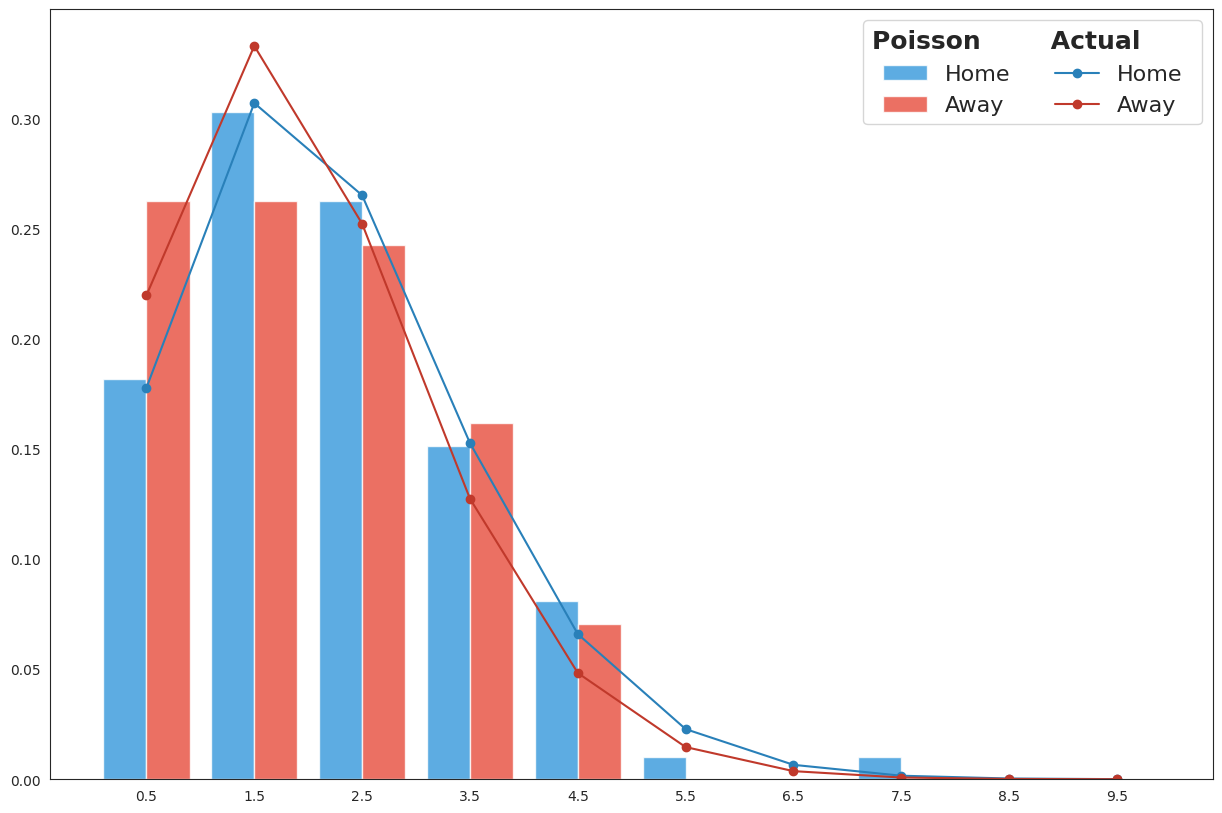

In [8]:
plt.figure(figsize=(15,10))
sns.set_style("white")
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(10)] for j in range(2)])
# plot histogram of actual goals
plt.hist(matches[['home_score', 'away_score']].values, range(11), alpha=0.8,
         label=['Home', 'Away'],density=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson        Actual      ", prop = {'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()

In [9]:
matches['id'] = range(1, len(matches) + 1)

In [10]:
def weight_from_tournament(tournament):
    priority = {
        'UAE Pro League': 1,
        "UAE President's Cup": 1,
        'UAE League Cup': 1,
        'AFC Champions League': 1
    }

    return priority[tournament]

# Filter matches based on match numbers
matches_filtered = matches[(matches['id'] >= 1) & (matches['id'] <= 100)].copy()

# Create weight column based on the tournament
matches_filtered.loc[:, 'weight'] = matches['tournament'].apply(weight_from_tournament)
matches_filtered.loc[:, 'weight'] = 1 / matches_filtered['weight']

# Create model data
matches_model_data = pd.concat([
    matches_filtered[['home_team', 'away_team', 'home_score', 'neutral', 'weight']].rename(
        columns={'home_team': 'team', 'away_team': 'opponent', 'home_score': 'goals'}),
    matches_filtered[['away_team', 'home_team', 'away_score', 'neutral', 'weight']].rename(
        columns={'away_team': 'team', 'home_team': 'opponent', 'away_score': 'goals'})
])



In [11]:
invalid_values = matches_model_data['weight'].isnull() | np.isinf(matches_model_data['weight'])

# Remove rows with invalid weights
matches_model_data = matches_model_data[~invalid_values]

# Re-run the Poisson regression model with the cleaned dataset
poisson_model = smf.glm(formula="goals ~ team + opponent", data=matches_model_data,
                        family=sm.families.Poisson()).fit()

In [12]:
def get_proba_match(foot_model, team1, team2, neutral=False, max_goals=10):
    if not neutral:
        # Get the average goal for each team when team1 is at home
        t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2}, index=[1])).values[0]
        t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1}, index=[1])).values[0]
    else:
        # Get the average goal for each team when team2 is at home
        t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2}, index=[1])).values[0]
        t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1}, index=[1])).values[0]

    # Get probability of all possible score for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [t1_goals_avg, t2_goals_avg]]

    # Do the product of the 2 vectors to get the matrix of the match
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))

    # Get the proba for each possible outcome
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]

    # Adjust the proba to sum to one
    result_proba =  np.array(result_proba)/ np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])]

In [13]:
def get_match_result(foot_model, team1, team2, neutral=False, elimination=False, max_draw=50, max_goals=10):
    # Get the proba
    proba, score_proba = get_proba_match(foot_model, team1, team2, neutral, max_goals)

    # Get the result, if it's an elimination game we have to be sure the result is not draw
    results = pd.Series([np.random.choice([team1, 'draw', team2], p=proba) for i in range(0,max_draw)]).value_counts()
    result = results.index[0] if not elimination or (elimination and results.index[0] != 'draw') else results.index[1]

    # If the result is not a draw game then we calculate the score of the winner from 1 to the max_goals
    # and the score of the looser from 0 to the score of the winner
    if (result != 'draw'):
        i_win, i_loose = (0,1) if result == team1 else (1,0)
        score_proba[i_win] = score_proba[i_win][1:]/score_proba[i_win][1:].sum(axis=0,keepdims=1)
        winner_score = pd.Series([np.random.choice(range(1, max_goals+1), p=score_proba[i_win]) for i in range(0,max_draw)]).value_counts().index[0]
        score_proba[i_loose] = score_proba[i_loose][:winner_score]/score_proba[i_loose][:winner_score].sum(axis=0,keepdims=1)
        looser_score = pd.Series([np.random.choice(range(0, winner_score), p=score_proba[i_loose]) for i in range(0,max_draw)]).value_counts().index[0]
        score = [winner_score, looser_score]
    # If it's a draw then we calculate a score and repeat it twice
    else:
        score = np.repeat(pd.Series([np.random.choice(range(0, max_goals+1), p=score_proba[0]) for i in range(0,max_draw)]).value_counts().index[0],2)
    looser = team2 if result == team1 else team1 if result != 'draw' else 'draw'
    return result, looser, score

In [14]:
initial_standings = {
    'team': ['Wasl', 'Ahli', 'Wahda', 'Ain', 'Nasr', 'Sharjah', 'Ajman', 'Jazira', 'Bataeh', 'Kalba', 'Baniyas', 'Khor Fakkan', 'Emirates', 'Hatta'],
    'matches_played': [22, 22, 23, 21, 23, 23, 22, 23, 22, 23, 22, 23, 21, 22],
    'goals_scored': [57, 56, 42, 46, 37, 45, 34, 45, 33, 35, 30, 30, 25, 16],
    'goal_difference': [34, 28, 14, 19, 6, 10, -8, 0, -7, -9, -12, -19, -23, -33],
    'points': [55, 49, 41, 39, 38, 35, 30, 28, 27, 24, 23, 21, 14, 8]
}

# Convert to DataFrame
league_table = pd.DataFrame(initial_standings)

In [15]:
league_table

,team,matches_played,goals_scored,goal_difference,points
0,Wasl,22,57,34,55
1,Ahli,22,56,28,49
2,Wahda,23,42,14,41
3,Ain,21,46,19,39
4,Nasr,23,37,6,38
5,Sharjah,23,45,10,35
6,Ajman,22,34,-8,30
7,Jazira,23,45,0,28
8,Bataeh,22,33,-7,27
9,Kalba,23,35,-9,24


In [16]:
def update_league_table(league_table, match_results):
    for match in match_results:
        team1, team2 = match['team1'], match['team2']
        score = match['score']
        if match['result'] == 'draw':
            league_table.loc[league_table['team'] == team1, 'points'] += 1
            league_table.loc[league_table['team'] == team2, 'points'] += 1
            league_table.loc[league_table['team'] == team1, 'goals_scored'] += score[0]
            league_table.loc[league_table['team'] == team2, 'goals_scored'] += score[1]
            league_table.loc[league_table['team'] == team1, 'goal_difference'] += 0
            league_table.loc[league_table['team'] == team2, 'goal_difference'] += 0
        else:
            league_table.loc[league_table['team'] == match['result'], 'points'] += 3
            league_table.loc[league_table['team'] == match['result'], 'goals_scored'] += score[0]
            league_table.loc[league_table['team'] == match['result'], 'goal_difference'] += score[0] - score[1]
            league_table.loc[league_table['team'] == match['looser'], 'goals_scored'] += score[1]
            league_table.loc[league_table['team'] == match['looser'], 'goal_difference'] -= score[0] - score[1]

        league_table.loc[league_table['team'] == team1, 'matches_played'] += 1
        league_table.loc[league_table['team'] == team2, 'matches_played'] += 1

    league_table.sort_values(by=['points', 'goal_difference', 'goals_scored'], ascending=False, inplace=True)
    league_table.reset_index(drop=True, inplace=True)
    return league_table
# Function to simulate and update league with new matches
def simulate_and_update_league(poisson_model, league_table, new_matches):
    match_results = []
    for index, match in new_matches.iterrows():
        result, looser, score = get_match_result(poisson_model, match['home_team'], match['away_team'], match['neutral'])
        match_results.append({
            'team1': match['home_team'],
            'team2': match['away_team'],
            'result': result,
            'looser': looser,
            'score': score
        })

    updated_league_table = update_league_table(league_table.copy(), match_results)
    return updated_league_table, match_results


In [17]:
new_matches = pd.DataFrame({
    'home_team': ['Jazira', 'Khor Fakkan', 'Bataeh', 'Wahda', 'Nasr', 'Kalba', 'Ahli'],
    'away_team': ['Emirates', 'Sharjah', 'Hatta', 'Ain', 'Ajman', 'Wasl', 'Baniyas'],
    'neutral': [False, False, False, False, False, False, False],
    'elimination': [False, False, False, False, False, False, False]
})

# Simulate and update league
updated_league_table, match_results = simulate_and_update_league(poisson_model, league_table, new_matches)

# Display results
print("Match Results:")
for match in match_results:
    print(f"{match['team1']} vs {match['team2']}: {match['score'][0]} - {match['score'][1]} ({match['result']})")

print("\nUpdated League Table:")
print(updated_league_table)

Match Results:
Jazira vs Emirates: 2 - 1 (Jazira)
Khor Fakkan vs Sharjah: 1 - 0 (Sharjah)
Bataeh vs Hatta: 2 - 0 (Bataeh)
Wahda vs Ain: 1 - 0 (Wahda)
Nasr vs Ajman: 1 - 0 (Nasr)
Kalba vs Wasl: 2 - 0 (Wasl)
Ahli vs Baniyas: 5 - 1 (Ahli)

Updated League Table:
           team  matches_played  goals_scored  goal_difference  points
0          Wasl              23            59               36      58
1          Ahli              23            61               32      52
2         Wahda              24            43               15      44
3          Nasr              24            38                7      41
4           Ain              22            46               18      39
5       Sharjah              24            46               11      38
6        Jazira              24            47                1      31
7        Bataeh              23            35               -5      30
8         Ajman              23            34               -9      30
9         Kalba              24

In [18]:
next_fixtures = pd.DataFrame({
    'home_team': ['Hatta', 'Ajman', 'Emirates', 'Wahda', 'Kalba', 'Wasl'],
    'away_team': ['Jazira', 'Sharjah', 'Nasr', 'Khor Fakkan','Baniyas', 'Ahli'],
    'neutral': [False, False, False, False, False, False],
    'elimination': [False, False, False, False, False, False]
})

# Simulate and update league with next set of fixtures
updated_league_table, match_results = simulate_and_update_league(poisson_model, updated_league_table, next_fixtures)

# Display results
print("Match Results:")
for match in match_results:
    print(f"{match['team1']} vs {match['team2']}: {match['score'][0]} - {match['score'][1]} ({match['result']})")

print("\nUpdated League Table:")
print(updated_league_table)

Match Results:
Hatta vs Jazira: 3 - 1 (Jazira)
Ajman vs Sharjah: 1 - 0 (Sharjah)
Emirates vs Nasr: 4 - 1 (Nasr)
Wahda vs Khor Fakkan: 1 - 0 (Wahda)
Kalba vs Baniyas: 3 - 0 (Kalba)
Wasl vs Ahli: 3 - 1 (Wasl)

Updated League Table:
           team  matches_played  goals_scored  goal_difference  points
0          Wasl              24            62               38      61
1          Ahli              24            62               30      52
2         Wahda              25            44               16      47
3          Nasr              25            42               10      44
4       Sharjah              25            47               12      41
5           Ain              22            46               18      39
6        Jazira              25            50                3      34
7        Bataeh              23            35               -5      30
8         Ajman              24            34              -10      30
9         Kalba              25            38               

In [19]:
mdthirteen_fixtures = pd.DataFrame({
    'home_team': ['Ajman', 'Emirates', 'Hatta', 'Ain'],
    'away_team': ['Baniyas', 'Bataeh', 'Ahli', 'Wasl'],
    'neutral': [False, False, False, False],
    'elimination': [False, False, False, False]
})

# Simulate and update league with next set of fixtures
updated_league_table, match_results = simulate_and_update_league(poisson_model, updated_league_table, mdthirteen_fixtures)

# Display results
print("Match Results:")
for match in match_results:
    print(f"{match['team1']} vs {match['team2']}: {match['score'][0]} - {match['score'][1]} ({match['result']})")

print("\nUpdated League Table:")
print(updated_league_table)

Match Results:
Ajman vs Baniyas: 1 - 0 (Ajman)
Emirates vs Bataeh: 1 - 0 (Bataeh)
Hatta vs Ahli: 5 - 0 (Ahli)
Ain vs Wasl: 3 - 0 (Wasl)

Updated League Table:
           team  matches_played  goals_scored  goal_difference  points
0          Wasl              25            65               41      64
1          Ahli              25            67               35      55
2         Wahda              25            44               16      47
3          Nasr              25            42               10      44
4       Sharjah              25            47               12      41
5           Ain              23            46               15      39
6        Jazira              25            50                3      34
7        Bataeh              24            36               -4      33
8         Ajman              25            35               -9      33
9         Kalba              25            38               -8      27
10      Baniyas              25            31              -

In [20]:
mdtwentysix_fixtures = pd.DataFrame({
    'home_team': ['Bataeh', 'Baniyas', 'Khor Fakkan', 'Sharjah', 'Jazira', 'Ahli', 'Nasr'],
    'away_team': ['Emirates', 'Ajman', 'Kalba', 'Wahda', 'Ain', 'Hatta', 'Wasl'],
    'neutral': [False, False, False, False, False, False, False],
    'elimination': [False, False, False, False, False, False, False]
})

# Simulate and update league with next set of fixtures
updated_league_table, match_results = simulate_and_update_league(poisson_model, updated_league_table, mdtwentysix_fixtures)

# Display results
print("Match Results:")
for match in match_results:
    print(f"{match['team1']} vs {match['team2']}: {match['score'][0]} - {match['score'][1]} ({match['result']})")

print("\nUpdated League Table:")
print(updated_league_table)

Match Results:
Bataeh vs Emirates: 2 - 1 (Bataeh)
Baniyas vs Ajman: 2 - 1 (Ajman)
Khor Fakkan vs Kalba: 2 - 1 (Kalba)
Sharjah vs Wahda: 2 - 0 (Wahda)
Jazira vs Ain: 1 - 0 (Ain)
Ahli vs Hatta: 3 - 1 (Ahli)
Nasr vs Wasl: 1 - 0 (Wasl)

Updated League Table:
           team  matches_played  goals_scored  goal_difference  points
0          Wasl              26            66               42      67
1          Ahli              26            70               37      58
2         Wahda              26            46               18      50
3          Nasr              26            42                9      44
4           Ain              24            47               16      42
5       Sharjah              26            47               10      41
6        Bataeh              25            38               -3      36
7         Ajman              26            37               -8      36
8        Jazira              26            50                2      34
9         Kalba              26    

In [21]:
mdalain_fixtures = pd.DataFrame({
    'home_team': ['Emirates', 'Ain'],
    'away_team': ['Ain', 'Bataeh'],
    'neutral': [False, False],
    'elimination': [False, False]
})

# Simulate and update league with next set of fixtures
updated_league_table, match_results = simulate_and_update_league(poisson_model, updated_league_table, mdalain_fixtures)

# Display results
print("Match Results:")
for match in match_results:
    print(f"{match['team1']} vs {match['team2']}: {match['score'][0]} - {match['score'][1]} ({match['result']})")

print("\nUpdated League Table:")
print(updated_league_table)

Match Results:
Emirates vs Ain: 1 - 0 (Ain)
Ain vs Bataeh: 3 - 1 (Ain)

Updated League Table:
           team  matches_played  goals_scored  goal_difference  points
0          Wasl              26            66               42      67
1          Ahli              26            70               37      58
2         Wahda              26            46               18      50
3           Ain              26            51               19      48
4          Nasr              26            42                9      44
5       Sharjah              26            47               10      41
6        Bataeh              26            39               -5      36
7         Ajman              26            37               -8      36
8        Jazira              26            50                2      34
9         Kalba              26            40               -7      30
10      Baniyas              26            32              -21      23
11  Khor Fakkan              26            31         